# Application 3: Pianello di Genga

After trained the models we can apply them to the real fragments.

In [4]:
%watermark -a "Lorenzo Cardarelli" -iv -v -m

Author: Lorenzo Cardarelli

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 151 Stepping 2, GenuineIntel
CPU cores   : 20
Architecture: 64bit

scipy      : 1.11.3
watermark  : 2.4.3
matplotlib : 3.7.1
PIL        : 9.5.0
torchvision: 0.15.2+cu118
cv2        : 4.8.0
skimage    : 0.21.0
pandas     : 2.0.2
numpy      : 1.24.3
seaborn    : 0.12.2
torch      : 2.0.1+cu118



## Imports

In [5]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import rescale, resize, downscale_local_mean

# pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.optim as optim


# training and utils imports
from sklearn.model_selection import train_test_split
from torchinfo import summary
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import r2_score
from tqdm import tqdm

from utils import *
from models import *
from dataset import *

Move computation to GPU if available.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
define_reproducibility(42)

Reproducibility is set to 42.


## Prepare data

In [8]:
pots = load_pots('new_dataset.npz').reshape(-1, 256, 256)

In [9]:
tabular_data = pd.read_excel('selected_info_new_dataset.xlsx')

In [10]:
encoders = fit_and_transform_encoders(tabular_data, ["Functional_class", "Morphology"])
transformed_data = transform_data_using_encoders(tabular_data[["Functional_class","Morphology"]], encoders)

## Fine-tuning step

In this step we fine-tune the model on the single context.

### Hyperparameters

In [11]:
BATCH_SIZE = 50
EPOCHS = 50
LEARNING_RATE = 0.001
IMG_SIZE = 128
LATENT_DIMS = 100
CATEGORICAL_FEATURES = transformed_data.shape[1]

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE, antialias=True),
    transforms.GaussianBlur(3),
    transforms.RandomRotation(5),
    transforms.RandomAffine(0, (0.01,0.01))
    ])

### Load all the models and weights

In [13]:
pretrained_model = CustomModel(num_classes=transformed_data.shape[1]).to(device)
pretrained_model.load_state_dict(torch.load("regressor_model.pth"))

<All keys matched successfully>

In [14]:
vae = reconstructionVAE(image_latent_dims=LATENT_DIMS).to(device)
vae.load_state_dict(torch.load('reconstructor_model.pth'))

<All keys matched successfully>

In [15]:
dae = DenoisingAutoencoder(latent_dims=LATENT_DIMS).to(device)
dae.load_state_dict(torch.load('denoiser_model.pth'))

<All keys matched successfully>

### Set up the models for fine-tuning

In [16]:
for param in pretrained_model.parameters():
    param.requires_grad = True

In [17]:
for param in vae.parameters():
    param.requires_grad = True

In [18]:
for param in dae.parameters():
    param.requires_grad = True

### Select data

In [19]:
selected_tabular = tabular_data.loc[tabular_data['context'] == "Pianello di Genga"]

In [20]:
selected_tabular.head()

,index,ids,context,context_typology,wide_chronology,funeral_function,ID_context,Functional_interpretation,Morphology,Functional_class,manufacturing_technique,material,Grave,Pag.,Fig./Tav.,n.,ID_biblio
1983,12367,PDG_0001,Pianello di Genga,Funerary,FBA,Cover,1,Scodella,Open shape,Class 1,Handmade,Impasto,2_1962,18.0,1,"A, 1",4
1984,12368,PDG_0002,Pianello di Genga,Funerary,FBA,Urn,1,Vaso a collo/Biconico,Closed shape,Class 3,Handmade,Impasto,4_1962,18.0,1,"B, 1",4
1985,12369,PDG_0003,Pianello di Genga,Funerary,FBA,Urn,1,Vaso a collo/Biconico,Closed shape,Class 3,Handmade,Impasto,5_1962,18.0,1,"C, 1",4
1986,12370,PDG_0004,Pianello di Genga,Funerary,FBA,Cover,1,Scodella,Open shape,Class 1,Handmade,Impasto,7_1962,19.0,2,"A, 1",4
1987,12371,PDG_0005,Pianello di Genga,Funerary,FBA,Urn,1,Anfora,Closed shape,Class 4,Handmade,Impasto,8_1962,19.0,2,"B, 1",4


Select also the tabular data

In [18]:
transformed_data_selected = transformed_data.loc[selected_tabular.index]

### Train and test split

In [19]:
test_size = 0.2

num_samples = len(selected_tabular)
num_samples_test = int(test_size * num_samples)


indices = list(range(num_samples))
indices_train, indices_test = train_test_split(indices, test_size=test_size, random_state=42)


pots_train = pots[selected_tabular.index][indices_train]
functional_encoded_train = transformed_data_selected.values[indices_train]

pots_test = pots[selected_tabular.index][indices_test]
functional_encoded_test = transformed_data_selected.values[indices_test]

### Prepare data for the model

In [20]:
pots_pytorch_trn = PotTorch(pots_train, functional_encoded_train, 
                            transform=transform, img_size=IMG_SIZE)

pots_pytorch_tst = PotTorch(pots_test, functional_encoded_test, 
                            transform=transform, img_size=IMG_SIZE)

In [21]:
data_loader_train = DataLoader(dataset = pots_pytorch_trn, batch_size=BATCH_SIZE, 
                               shuffle=True, drop_last=True)

data_loader_test = DataLoader(dataset = pots_pytorch_tst, batch_size=BATCH_SIZE, 
                              shuffle=True, drop_last=True)

In [22]:
pot, masked_img, padded_tensor, bounding_box, scale_factor, archeo_info, mask, x_filled = next(iter(data_loader_train))

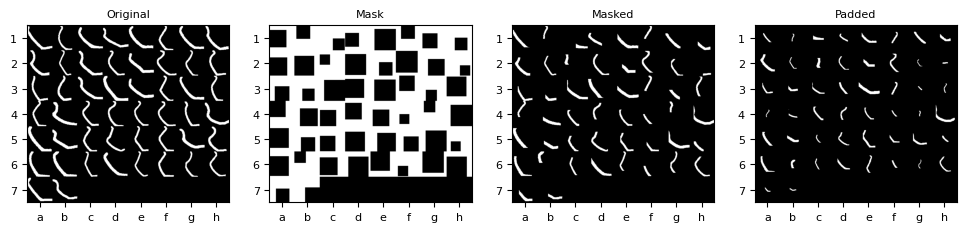

In [23]:
plot_batches([pot, mask, masked_img, padded_tensor], 
             title_list=["Original", "Mask", "Masked", "Padded"], 
             figsize=(12, 8), nrow=8, title_size=8, tick_size=8)

### Regression step

In [24]:
fine_tuned_regressor = RegressorFineTuner(pretrained_model, 
                                          20, 
                                          data_loader_train, 
                                          data_loader_test, 
                                          lr=0.0005, 
                                          BATCH_SIZE=BATCH_SIZE, 
                                          device=device) 

Training Progress:   5%|▌         | 1/20 [00:02<00:49,  2.59s/it]

Epoch [1/20] - Training Loss: 0.0058 - Testing Loss: 0.0060


Training Progress:  30%|███       | 6/20 [00:12<00:27,  1.95s/it]

Epoch [6/20] - Training Loss: 0.0041 - Testing Loss: 0.0039


Training Progress:  55%|█████▌    | 11/20 [00:21<00:16,  1.79s/it]

Epoch [11/20] - Training Loss: 0.0036 - Testing Loss: 0.0024


Training Progress:  80%|████████  | 16/20 [00:29<00:07,  1.77s/it]

Epoch [16/20] - Training Loss: 0.0035 - Testing Loss: 0.0027


Training Progress: 100%|██████████| 20/20 [00:36<00:00,  1.85s/it]


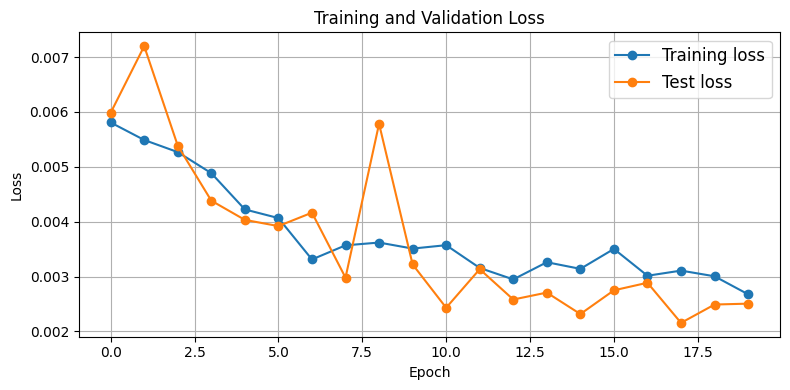

In [25]:
fine_tuned_regressor.plot_losses()

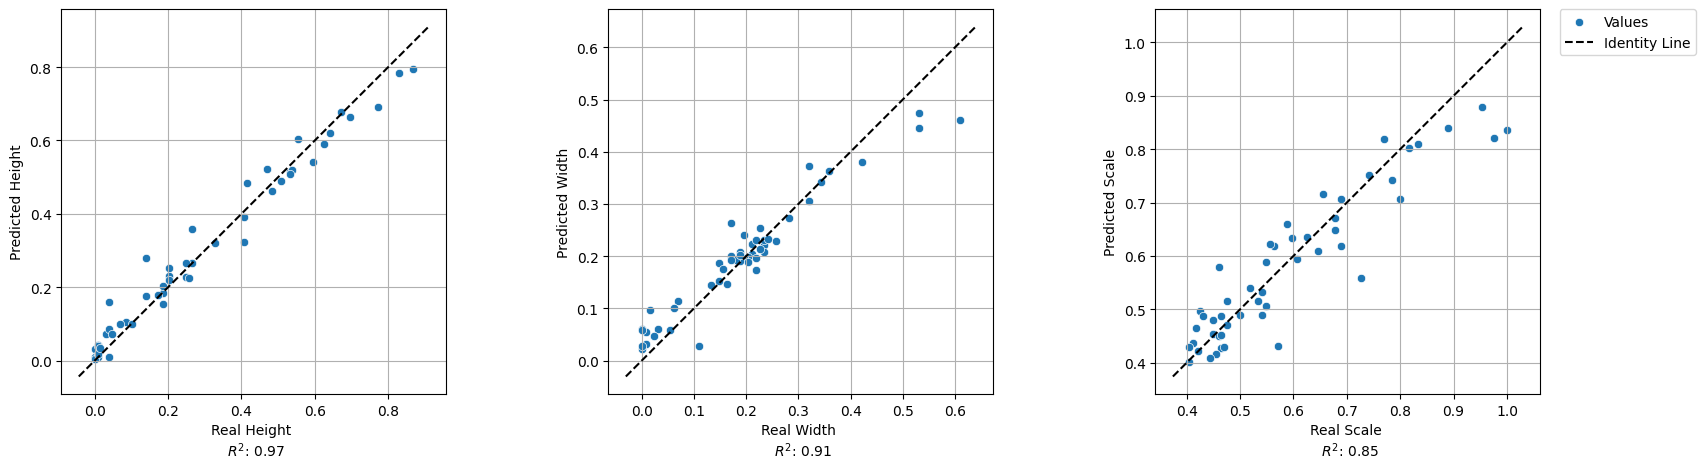

In [26]:
fine_tuned_regressor.r_square_plot()

## Denoising step

In [27]:
dae_fine_tuned = DAEFineTuner(dae, 
                              20, 
                              data_loader_train, 
                              data_loader_test, 
                              mask_weight=0.2, 
                              lr=0.0005, 
                              BATCH_SIZE=BATCH_SIZE, 
                              device=device)

Training Progress:   5%|▌         | 1/20 [00:01<00:28,  1.48s/it]

Epoch [1/20] - Training Loss: 6170.2372 - Testing Loss: 8013.9902


Training Progress:  30%|███       | 6/20 [00:09<00:22,  1.62s/it]

Epoch [6/20] - Training Loss: 3505.6943 - Testing Loss: 3281.5784


Training Progress:  55%|█████▌    | 11/20 [00:17<00:14,  1.56s/it]

Epoch [11/20] - Training Loss: 3175.1906 - Testing Loss: 3066.0544


Training Progress:  80%|████████  | 16/20 [00:25<00:06,  1.60s/it]

Epoch [16/20] - Training Loss: 3070.5627 - Testing Loss: 3152.9067


Training Progress: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


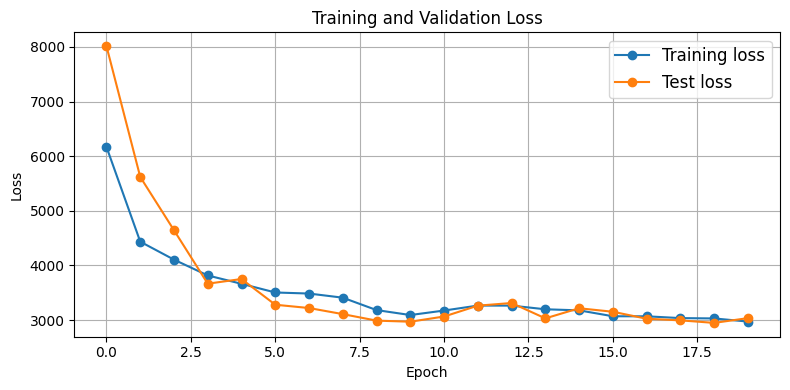

In [28]:
dae_fine_tuned.plot_losses()

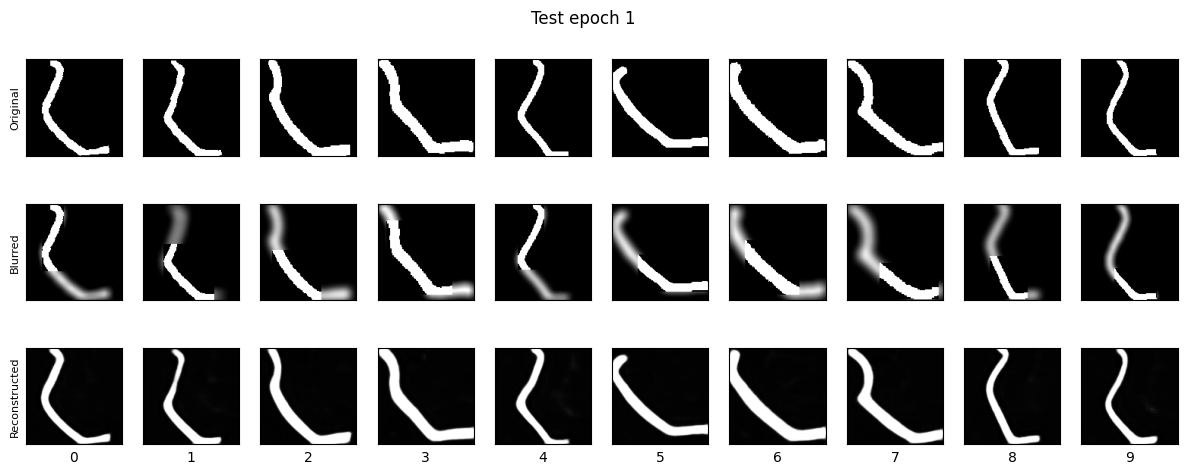

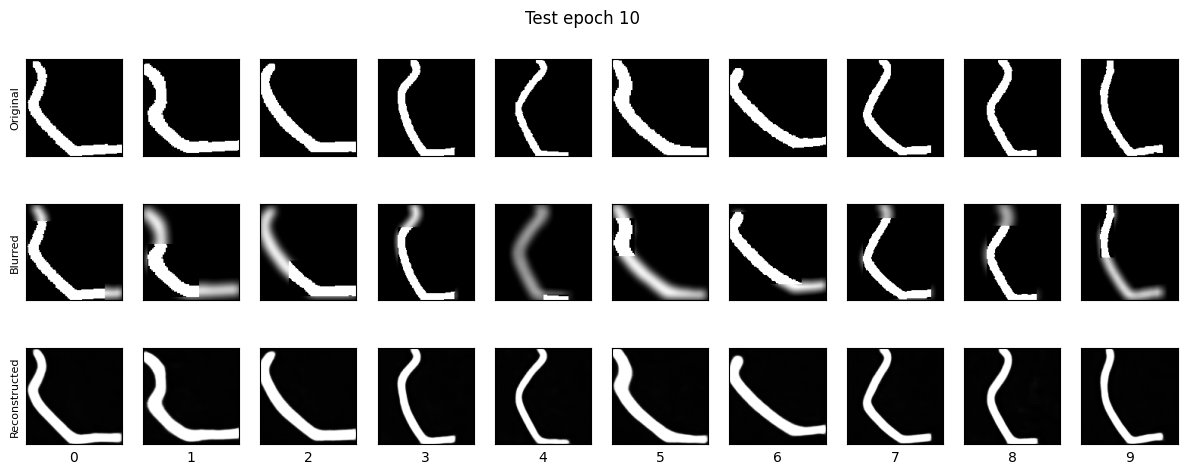

In [29]:
dae_fine_tuned.plot_outputs([0, 9], output_set="test")

### Reconstruction step

In [30]:
vae_fine_tuned = VAEFineTuner(vae, 
                              20, 
                              data_loader_train, 
                              data_loader_test, 
                              loss="MSE", 
                              mask_weight=0.2, 
                              lr=0.0005, 
                              BATCH_SIZE=BATCH_SIZE, 
                              device=device)

Training Progress:   5%|▌         | 1/20 [00:01<00:32,  1.69s/it]

Epoch [1/20] - Training Loss: 18435.7576 - Testing Loss: 19296.9551


Training Progress:  30%|███       | 6/20 [00:09<00:21,  1.50s/it]

Epoch [6/20] - Training Loss: 14824.7969 - Testing Loss: 14351.3359


Training Progress:  55%|█████▌    | 11/20 [00:16<00:13,  1.48s/it]

Epoch [11/20] - Training Loss: 13455.1587 - Testing Loss: 14398.5469


Training Progress:  80%|████████  | 16/20 [00:24<00:05,  1.50s/it]

Epoch [16/20] - Training Loss: 13268.6135 - Testing Loss: 12498.0654


Training Progress: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


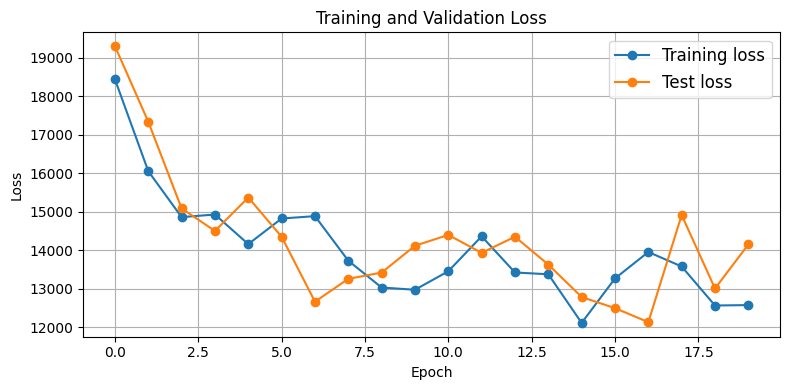

In [31]:
vae_fine_tuned.plot_losses()

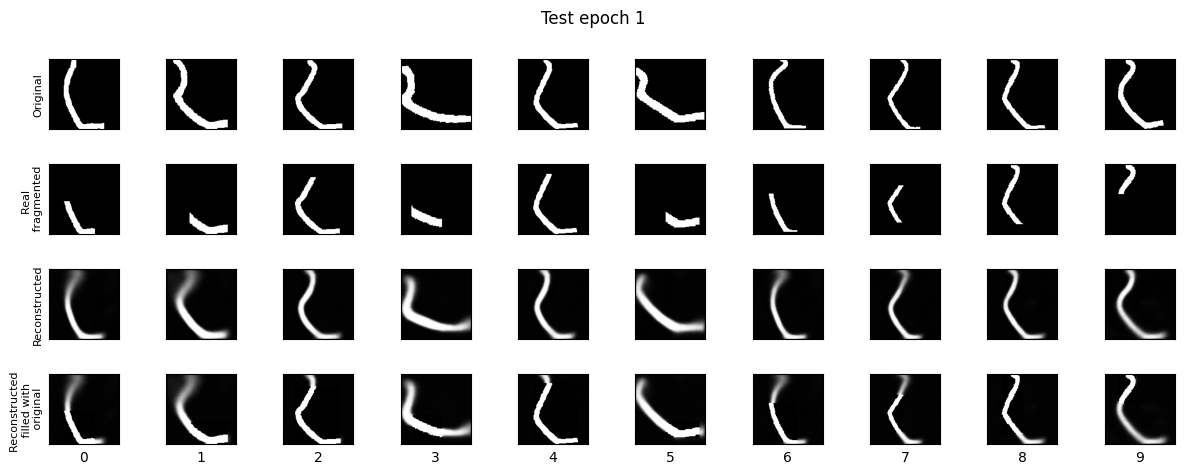

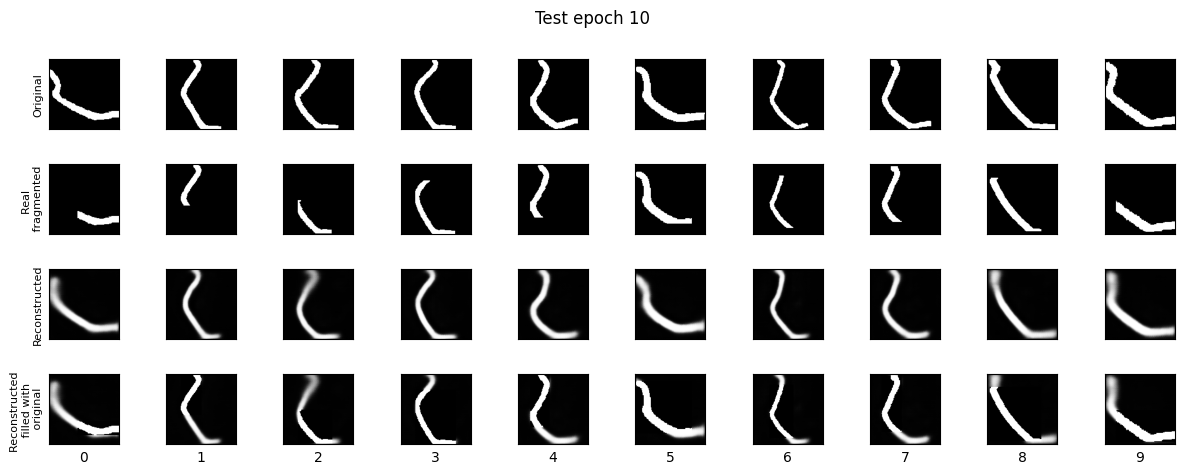

In [32]:
vae_fine_tuned.plot_outputs([0, 9], output_set="test")

## Application to actual framgents

In [33]:
# Import some additional libraries

import os
from pathlib import Path
from PIL import Image

Read the fragment images

In [34]:
imgs_frag = read_and_denoise_imgs(r"materials_frag\PDG_frag")

Read the tabular data associated to the fragments

In [35]:
info_fragments = pd.read_excel(r"materials_frag\fragments.xlsx")

Select the context's fragments

In [36]:
info_fragments_selected = info_fragments[info_fragments["context"].isin(["Pianello di Genga"])].reset_index(drop=True)

info_fragments_selected = info_fragments_selected.loc[info_fragments_selected.Functional_class.dropna().index]

Transform the labels according to the model

In [37]:
transformed_data = transform_data_using_encoders(info_fragments_selected[["Functional_class", "Morphology"]], encoders) #"Functional_class"

Select images according to the tabular information

In [38]:
imgs_frag = imgs_frag[info_fragments_selected.index]

Define some transformations (no augmentation)

In [39]:
transform_rec = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE, antialias=True),
    ])

And define a PotTorch dataset, similiar to the one used for training

In [40]:
potds_pytorch_real_frag = PotTorch(imgs_frag, transformed_data.values, transform=transform_rec, img_size=IMG_SIZE)

Define a batch size. If the dataset is too big, it can be divided in batches. A batch can contain a limit of 128 images, like in the training phase.

In [41]:
if len(imgs_frag) <= 128:
    batch_size = len(imgs_frag)
else:
    batch_size = 128 # or specify the batch size you want here


Create a dataloader

In [42]:
data_loader_real_frag = DataLoader(dataset = potds_pytorch_real_frag, batch_size=batch_size, shuffle=False, drop_last=False)

Using a custom function, we can apply the *Regressor* to the images. The function will return a folder with the predicted positions, that can be used to verify the results.

In [43]:
#predict_fragments(data_loader_real_frag, pretrained_model, batch_size, context_name = "PDG", df_ids=info_fragments_selected)

Once the positions are checked, we can continue with the reconstruction step.

In [44]:
files_path= read_img_files(r"img_pos_PDG")

In [45]:
imgs_pos = []
for img_file in files_path:
    x = Image.open(img_file).convert("L")
    x = np.array(x)
    x = 255 - x
    x = denoise_and_binarize(x)
    imgs_pos.append(x)

In [46]:
imgs_pos = np.array(imgs_pos)

Create a new dataset and dataloader for the reconstruction step

In [47]:
potds_pytorch_real_frag = PotTorch(imgs_pos, transformed_data.values, transform=transform_rec, img_size=IMG_SIZE)

In [48]:
data_loader_real_frag = DataLoader(dataset = potds_pytorch_real_frag, batch_size=batch_size, shuffle=False, drop_last=False)

In [49]:
reconstructed_imgs = []
pot_list = []

for batch, (pot, _, _, _, _, archeo_info, _, _) in enumerate(data_loader_real_frag):

    pot = pot.to(device).float()
    archeo_info = archeo_info.to(device).float()

    encoded, z_mean, z_log_var, decoded = vae_fine_tuned.model(pot)

    reconstructed_imgs.append(decoded.detach().cpu())
    pot_list.append(pot.detach().cpu())

reconstructed_imgs = torch.cat(reconstructed_imgs, dim=0)
pot_list = torch.cat(pot_list, dim=0)

Create the "Reconstructed filled with original" images

In [50]:
row_mask = torch.all(torch.eq(pot_list, 0), dim=3, keepdim=True)
col_mask = torch.all(torch.eq(pot_list, 0), dim=2, keepdim=True)
x_filled = torch.where(row_mask, reconstructed_imgs, pot_list)
rec_filled = torch.where(col_mask, reconstructed_imgs, x_filled)

In [51]:
decoded_filled = rec_filled.to(device).float()
decoded = dae(decoded_filled)  

And visualise the results

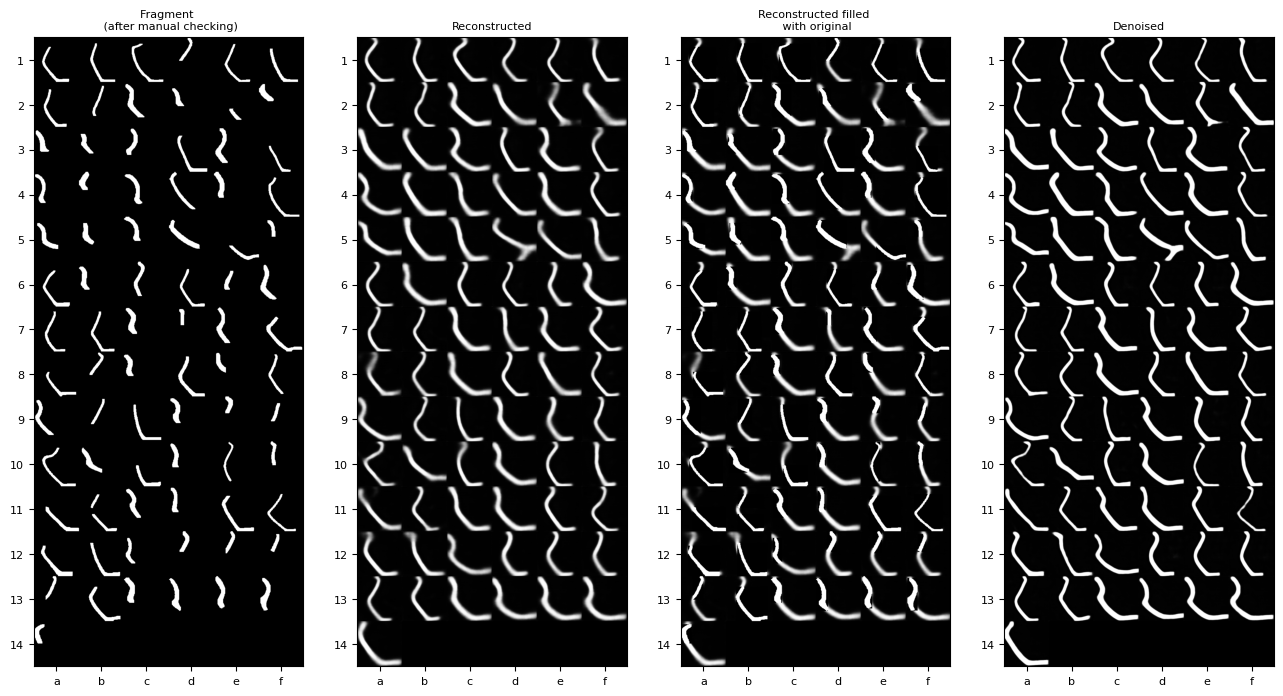

In [52]:
plot_batches([pot_list, reconstructed_imgs, rec_filled, decoded], 
             title_list=["Fragment \n (after manual checking)", "Reconstructed", "Reconstructed filled \n with original", "Denoised"], 
             figsize=(16, 10), nrow=6, title_size=8, tick_size=8, save_fig=True)

## Human evaluation

Evaluate the results of the reconstruction using a human evaluator.

### First approach. Discrimination between real and fake

In [53]:
from skimage.transform import resize
import random
from skimage.morphology import disk
from skimage.filters import median

from scipy.sparse import csr_matrix, save_npz

In [54]:
frag_decoded_numpy = decoded.cpu().detach().numpy()
frag_decoded_numpy = frag_decoded_numpy.squeeze(1)

Select real pots

In [55]:
pots_metrics = pots[selected_tabular.index]

In [56]:
pots_metrics_rescaled = []
for pot in pots_metrics:
    x = resize(pot, (128, 128), anti_aliasing=False)
    pots_metrics_rescaled.append(x)

pots_metrics_rescaled = np.array(pots_metrics_rescaled)

In [57]:
pots_metrics_rescaled.shape

(250, 128, 128)

Select a number of original images equal to the number of the reconstructed images

In [58]:
selected_index = np.random.choice(np.arange(len(pots_metrics)), len(frag_decoded_numpy), replace=False)

In [59]:
frag_decoded_numpy_list  = []
for i in range(len(frag_decoded_numpy)):
    x = denoise_and_binarize(frag_decoded_numpy[i])
    
    min_img = minimum_image(x, margin=2)
    postprocessed = pad_image_postprocessing(min_img, 128)
    resized = resize(postprocessed, (128, 128), anti_aliasing=False)
    resized = remove_small_objects(resized, min_size=resized.astype(np.uint8).sum()/2)

    frag_decoded_numpy_list.append(resized)
    

frag_decoded_numpy_noised = np.array(frag_decoded_numpy_list)

In [60]:
decoded_real_numpy = np.array([median(img, disk(0)) for img in pots_metrics_rescaled[selected_index]])

frag_decoded_numpy = np.array([median(img, disk(0)) for img in frag_decoded_numpy_noised])

Concatenate the original images and the reconstructed images

In [61]:
stacked = np.vstack((frag_decoded_numpy, decoded_real_numpy))

Create a dataframe containing the images

In [62]:
df_res = pd.DataFrame(range(0, len(stacked)), columns=["ID_real"])
df_res["type"] = ["reconstructed"] * len(frag_decoded_numpy) + ["real"] * len(decoded_real_numpy)
stacked_flatten = stacked.reshape(stacked.shape[0], -1)

### Add the images to the dataframe
df_res["img"] = [img for img in stacked_flatten]

id_df_shuffle =df_res.ID_real.values.copy()

random.shuffle(id_df_shuffle)

### Set the shuffled IDs
df_res["ID_shuffle"] = id_df_shuffle
df_res.sort_values(by="ID_shuffle", inplace=True)
df_res.set_index("ID_shuffle", inplace=True)
df_res.reset_index(inplace = True)

df_res.to_excel("HE/PDG/reconstructed_real_pdg.xlsx", index=True)

df_res.reset_index(inplace=True)

In [63]:
reordered_array = []
for i, row in df_res.iterrows():
    reordered_array.append(stacked_flatten[row.ID_real])

reordered_array = np.array(reordered_array)

Save the images

In [64]:
#save_npz("HE/PDG/first_eval_pdg.npz", csr_matrix(reordered_array))

In [65]:
#pdf_filename = "output_first_eval_pdg.pdf"

#create_pdf_first_eval(df_res, pdf_filename, id_df =df_res.index,  images_per_page=12)

### Second approach. Archaelogical features evaluation

In [66]:
pot_list_numpy = pot_list.cpu().detach().numpy()
decoded_numpy = decoded.cpu().detach().numpy()

pot_list_numpy = pot_list_numpy.squeeze(1)
decoded_numpy = decoded_numpy.squeeze(1)

In [67]:
decoded_numpy_list  = []
for i in range(len(decoded_numpy)):
    x = denoise_and_binarize(decoded_numpy[i])
    min_img = minimum_image(x, margin=2)
    postprocessed = pad_image_postprocessing(min_img, 128)
    resized = resize(postprocessed, (128, 128), anti_aliasing=False)
    resized = remove_small_objects(resized, min_size=resized.astype(np.uint8).sum()/2)

    decoded_numpy_list.append(resized)

decoded_numpy = np.array(decoded_numpy_list)

In [68]:
pdf_filename = "output_second_eval_pdg.pdf"
create_pdf_second_eval(pot_list_numpy, decoded_numpy, pdf_filename, id_df=df_res.index, images_per_page=10)

### Analysis example

In [72]:
pots_metrics_rescaled.shape

(250, 128, 128)

In [103]:
frag_decoded_numpy.shape

(79, 128, 128)

In [104]:
concatendated = np.concatenate((frag_decoded_numpy, pots_metrics_rescaled), axis=0)

In [105]:
conc_index = np.arange(len(concatendated))   

In [106]:
analysis_df = pd.DataFrame(index=conc_index)
analysis_df["type"] = ["Reconstructed"] * len(frag_decoded_numpy) + ["Real"] * len(pots_metrics_rescaled)

In [107]:
import umap

In [108]:
ump = umap.UMAP(n_neighbors=10, min_dist=0.05, metric='cosine', random_state=42, n_epochs=500).fit(concatendated.reshape(concatendated.shape[0], -1))

In [109]:
ump_red = ump.transform(concatendated.reshape(concatendated.shape[0], -1))

<Axes: >

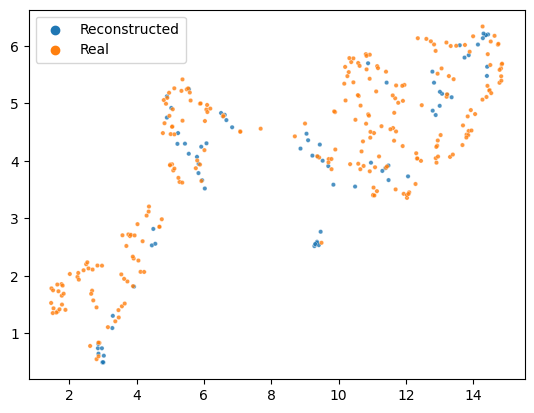

In [112]:
sns.scatterplot(x=ump_red[:, 0], y=ump_red[:, 1], hue=analysis_df.type.values, s=10, alpha=0.8)